# Head Pose by Azure API
視覺化 Azure Head pose API 得到的結果

In [1]:
import pickle
from pathlib import Path
from random import choice, sample

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import io

In [15]:
def transform(image,
              translation=(0, 0, 0),
              rotation=(0, 0, 0),
              scaling=(1, 1, 1),
              shearing=(0, 0, 0)):
    
    # get the values on each axis
    t_x, t_y, t_z = translation
    r_x, r_y, r_z = rotation
    sc_x, sc_y, sc_z = scaling
    sh_x, sh_y, sh_z = shearing
    
    # convert degree angles to rad
    theta_rx = np.deg2rad(r_x)
    theta_ry = np.deg2rad(r_y)
    theta_rz = np.deg2rad(r_z)
    theta_shx = np.deg2rad(sh_x)
    theta_shy = np.deg2rad(sh_y)
    theta_shz = np.deg2rad(sh_z)
    
    # get the height and the width of the image
    h, w = image.shape[:2]
    # compute its diagonal
    diag = (h ** 2 + w ** 2) ** 0.5
    # compute the focal length
    f = diag
    if np.sin(theta_rz) != 0:
        f /= 2 * np.sin(theta_rz)
        
    # set the image from cartesian to projective dimension
    H_M = np.array([[1, 0, -w / 2],
                    [0, 1, -h / 2],
                    [0, 0,      1],
                    [0, 0,      1]])
    # set the image projective to carrtesian dimension
    Hp_M = np.array([[f, 0, w / 2, 0],
                     [0, f, h / 2, 0],
                     [0, 0,     1, 0]])
    
    # adjust the translation on z
    t_z = (f - t_z) / sc_z ** 2
    # translation matrix to translate the image
    T_M = np.array([[1, 0, 0, t_x],
                    [0, 1, 0, t_y],
                    [0, 0, 1, t_z],
                    [0, 0, 0,  1]])
    
    # calculate cos and sin of angles
    sin_rx, cos_rx = np.sin(theta_rx), np.cos(theta_rx)
    sin_ry, cos_ry = np.sin(theta_ry), np.cos(theta_ry)
    sin_rz, cos_rz = np.sin(theta_rz), np.cos(theta_rz)
    # get the rotation matrix on x axis
    R_Mx = np.array([[1,      0,       0, 0],
                     [0, cos_rx, -sin_rx, 0],
                     [0, sin_rx,  cos_rx, 0],
                     [0,      0,       0, 1]])
    # get the rotation matrix on y axis
    R_My = np.array([[cos_ry, 0, -sin_ry, 0],
                     [     0, 1,       0, 0],
                     [sin_ry, 0,  cos_ry, 0],
                     [     0, 0,       0, 1]])
    # get the rotation matrix on z axis
    R_Mz = np.array([[cos_rz, -sin_rz, 0, 0],
                     [sin_rz,  cos_rz, 0, 0],
                     [     0,       0, 1, 0],
                     [     0,       0, 0, 1]])
    # compute the full rotation matrix
    # R_M = np.dot(np.dot(R_Mx, R_My), R_Mz)
    R_M = np.dot(np.dot(R_Mx, R_Mz), R_My)
    # R_M = np.linalg.inv(R_M)
   
    
    # get the scaling matrix
    Sc_M = np.array([[sc_x,     0,    0, 0],
                     [   0,  sc_y,    0, 0],
                     [   0,     0, sc_z, 0],
                     [   0,     0,    0, 1]])


    Identity = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])
    
    # get the tan of angles
    tan_shx = np.tan(theta_shx)
    tan_shy = np.tan(theta_shy)
    tan_shz = np.tan(theta_shz)
    # get the shearing matrix on x axis
    Sh_Mx = np.array([[      1, 0, 0, 0],
                      [tan_shy, 1, 0, 0],
                      [tan_shz, 0, 1, 0],
                      [      0, 0, 0, 1]])
    # get the shearing matrix on y axis
    Sh_My = np.array([[1, tan_shx, 0, 0],
                      [0,       1, 0, 0],
                      [0, tan_shz, 1, 0],
                      [0,       0, 0, 1]])
    # get the shearing matrix on z axis
    Sh_Mz = np.array([[1, 0, tan_shx, 0],
                      [0, 1, tan_shy, 0],
                      [0, 0,       1, 0],
                      [0, 0,       0, 1]])
    # compute the full shearing matrix
    Sh_M = np.dot(np.dot(Sh_Mx, Sh_My), Sh_Mz)
    
    
    # compute the full transform matrix
    M = Identity
    M = np.dot(T_M,  M)
    M = np.dot(R_M,  M)
    M = np.dot(Sc_M, M)
    M = np.dot(Sh_M, M)
    M = np.dot(Hp_M, np.dot(M, H_M))
    # apply the transformation
    image = cv2.warpPerspective(image, M, (w, h))
    return image, M, R_M, Hp_M, np.array([t_x, t_y, t_z])

In [3]:
BODY_DIR = Path('r256/images')

In [4]:
ps = sorted(p for p in Path('align_2.0/face').expanduser().glob('*.png'))
pmap = {p.stem: p for p in ps}
len(ps)

27753

In [5]:
ann = pickle.load(open('df_azure_faceAPI_anno.pkl', 'rb'))

In [6]:
# camera_matrix = np.array([[1, 0, 128],
#                           [0, 1, 128],
#                           [0, 0,   1]], dtype="double")
# dist_coeffs = np.zeros((4,1))
# translation_vector = np.array([0.0, 0.0, 0.0])

In [67]:
from math import cos, sin
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = -(pitch * np.pi / 180)
    yaw = (yaw * np.pi / 180)
    roll = -(roll * np.pi / 180)

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(255,0,0),1)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),1)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(0,0,255),1)

    return img

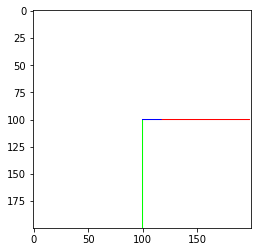

In [68]:
# img = np.ones((200, 200, 3), dtype=np.uint8) * 255
# img = draw_axis(img, 10, 0, 0)
# plt.imshow(img)

face 0
box: [116, 15, 151, 60]
head_pose: {'roll': -2.2, 'yaw': 3.9, 'pitch': -5.4}


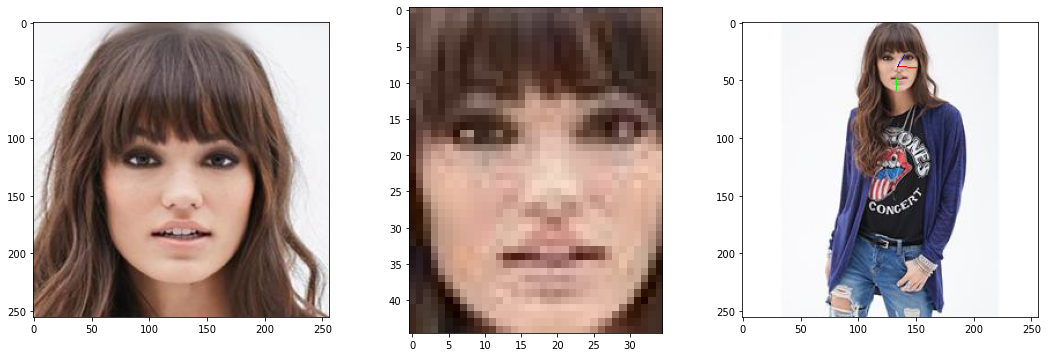

face 0
box: [124, 10, 151, 47]
head_pose: {'roll': -5.9, 'yaw': 4.6, 'pitch': -1.9}


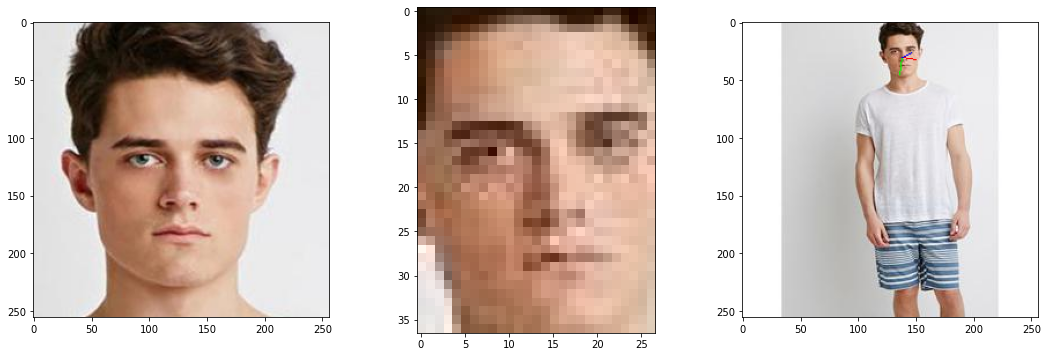

face 0
box: [118, 11, 137, 36]
head_pose: {'roll': 5.9, 'yaw': 15.2, 'pitch': -12.2}


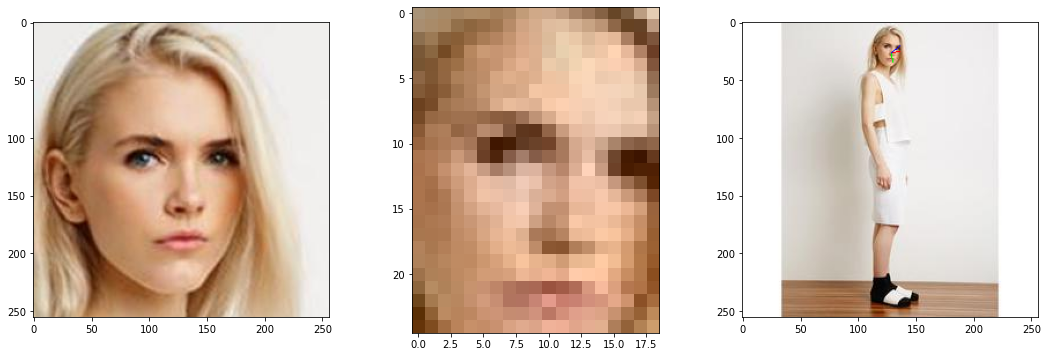

face 0
box: [146, 11, 180, 62]
head_pose: {'roll': 2.8, 'yaw': 3.0, 'pitch': -2.5}


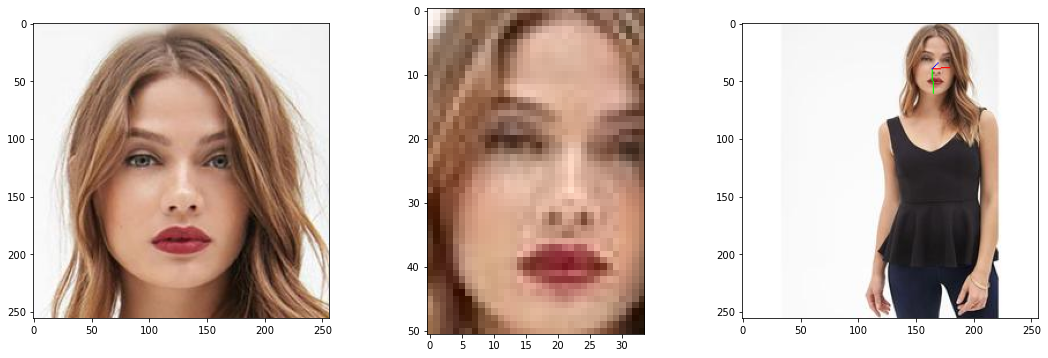

face 0
box: [111, 15, 146, 57]
head_pose: {'roll': 18.5, 'yaw': 6.1, 'pitch': -9.3}


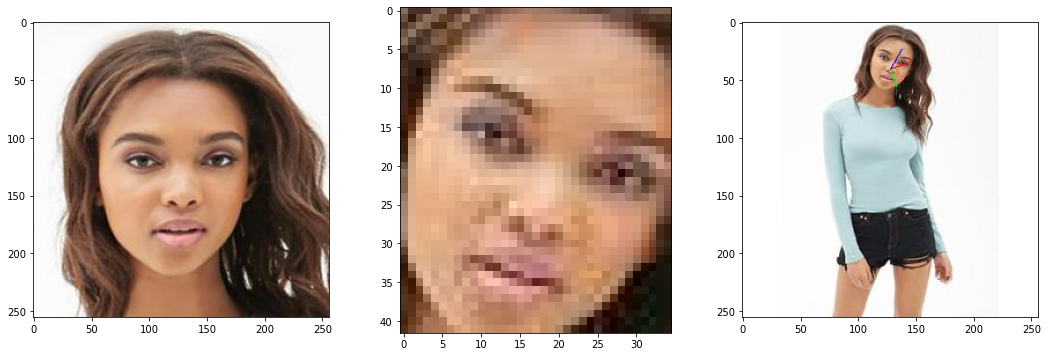

face 0
box: [126, 9, 147, 39]
head_pose: {'roll': 13.4, 'yaw': -16.3, 'pitch': -9.3}


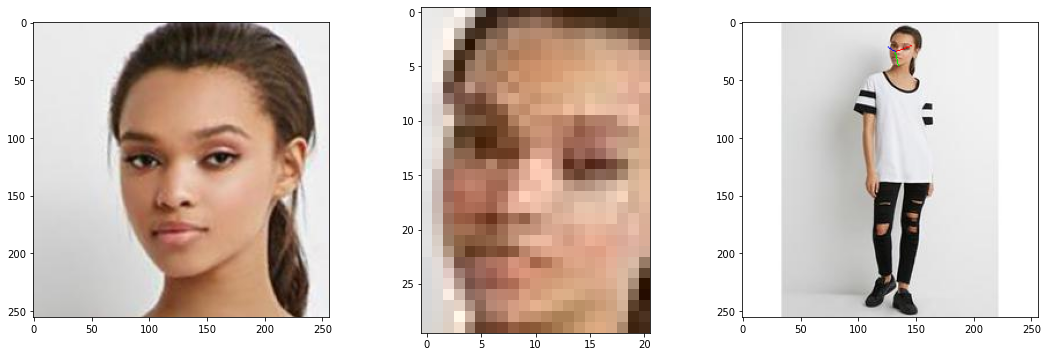

face 0
box: [100, 10, 121, 36]
head_pose: {'roll': -30.0, 'yaw': 10.0, 'pitch': -7.8}


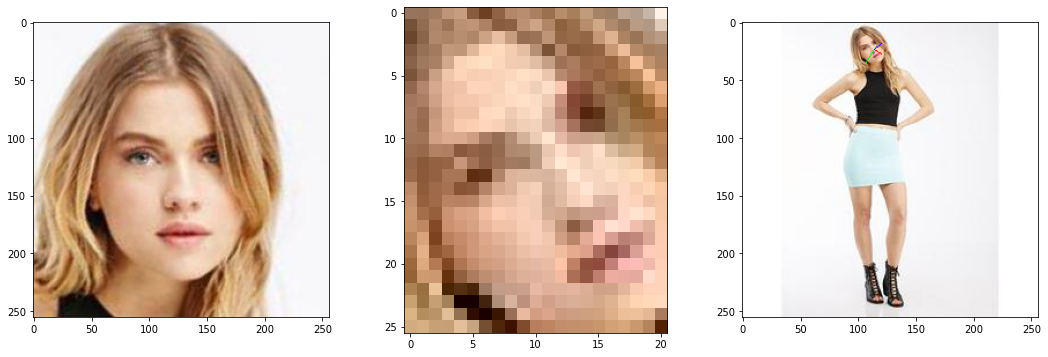

face 0
box: [99, 6, 134, 53]
head_pose: {'roll': -0.2, 'yaw': 18.9, 'pitch': -6.7}


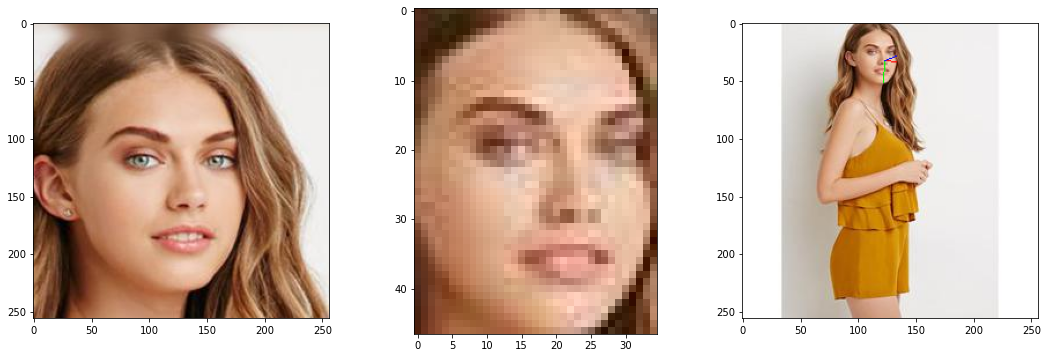

face 0
box: [130, 13, 154, 41]
head_pose: {'roll': 26.6, 'yaw': 31.5, 'pitch': 1.1}


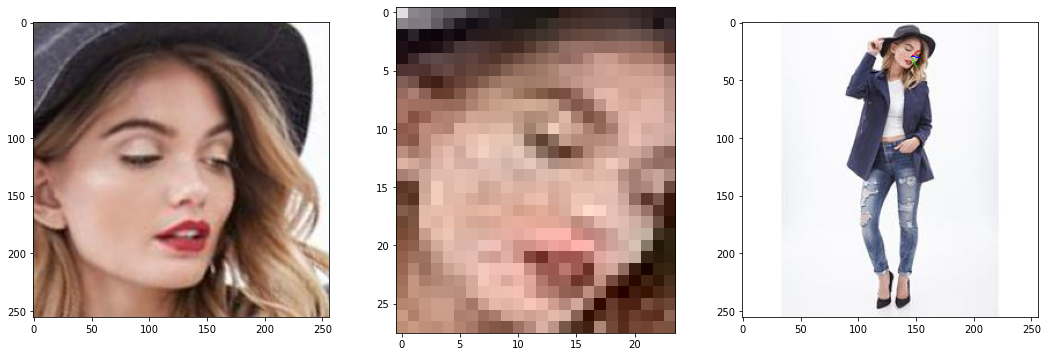

face 0
box: [105, 10, 124, 36]
head_pose: {'roll': 0.3, 'yaw': 0.3, 'pitch': -8.6}


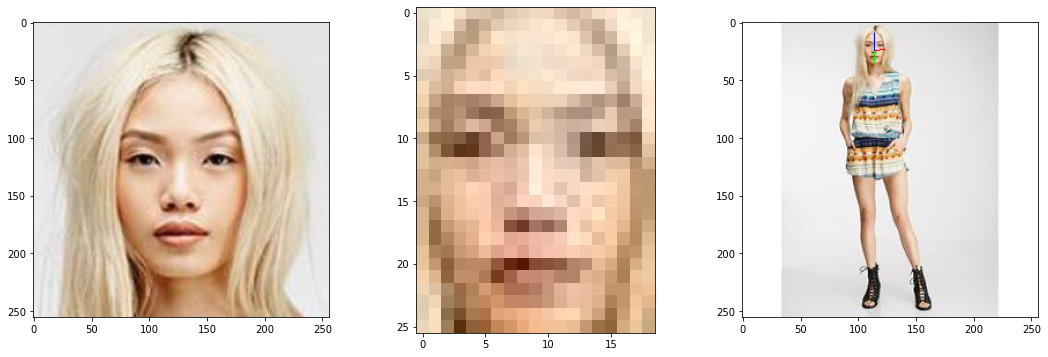

In [69]:
for p in sample(ps, 10):
    faces = ann[p.stem]
    fig, axs = plt.subplots(1,len(faces) * 2 + 1, figsize=(6 * (len(faces) * 2 + 1), 6))
    face_img = io.imread(p)
    body_img = io.imread(BODY_DIR / p.name)
    axs[0].imshow(face_img)
    
    for i, face in enumerate(faces):
        print("face", i)
        print("box:", face['face_rect'])
        print("head_pose:", face['head_pose'])
        roll, pitch, yaw = face['head_pose']['roll'], face['head_pose']['pitch'], face['head_pose']['yaw']
        x1, y1, x2, y2 = face['face_rect']
        
        
        # (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
        body_draw = body_img.copy() #[y1:y2, x1:x2, :].copy()
        face_crop = body_img[y1:y2, x1:x2, :].copy()
        axs[i*2 + 1].imshow(face_crop)
#         body_trans, M, R_M, Hp_M, translation_vector = transform(body_draw, (0.0, 0.0, 0.0), (roll, pitch, yaw), (1, 1, 1), (0.0, 0.0, 0.0))
        
#         p1 = ( face['landmark']['nose_tip']['x'], face['landmark']['nose_tip']['y'] )
#         camera_matrix = Hp_M[:, :3]
#         rotation_vector, _ = cv2.Rodrigues(R_M[:3,:3])
# #         translation_vector = np.array([p1[0], p1[1], 0.0])
#         (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
#         print("nose end:", nose_end_point2D)

#         p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
#         cv2.line(body_draw, (int(p1[0]), int(p1[1])), p2, (0,255,0), 2)
        face_crop = draw_axis(face_crop, yaw, pitch, roll, int(face['landmark']['nose_tip']['x'] - x1), int(face['landmark']['nose_tip']['y'] - y1))
        body_draw[y1:y2, x1:x2, :] = face_crop
        axs[i*2 + 2].imshow(body_draw)

    plt.show()